negative: 68 枚
positive: 69 枚
正解ラベル (array([0, 1], dtype=int64), array([68, 69], dtype=int64))
予測ラベル (array([0, 1], dtype=int64), array([48, 89], dtype=int64))


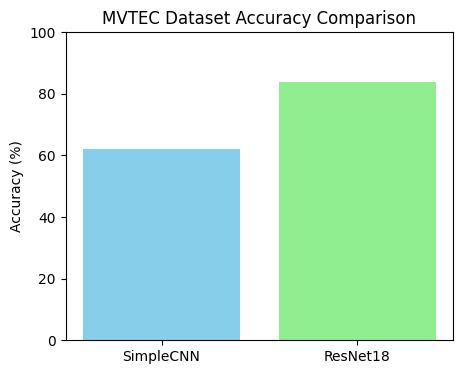

SimpleCNN 正答率: 62.04%
ResNet18 正答率: 83.94%


C:\Users\AtsukiSakamoto\anaconda3\envs\pytorch_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\AtsukiSakamoto\anaconda3\envs\pytorch_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35299 (\N{CJK UNIFIED IDEOGRAPH-89E3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\AtsukiSakamoto\anaconda3\envs\pytorch_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12463 (\N{KATAKANA LETTER KU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\AtsukiSakamoto\anaconda3\envs\pytorch_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\AtsukiSakamoto\anaconda3\envs\pytorch_env\lib\site-packages\IPython

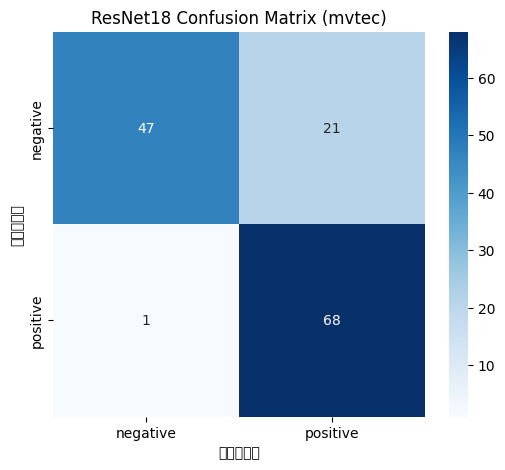

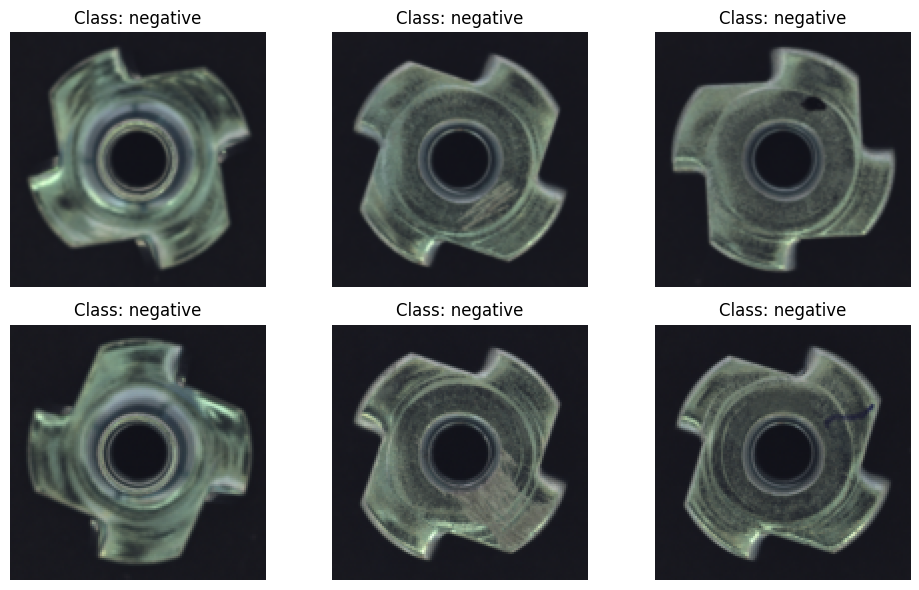

In [2]:
# analysis.ipynb 例（Jupyter Notebookで使用）
# 目的：学習結果をグラフや混同行列で可視化してレポートをまとめる
"""
これでできること
1. 正答率の棒グラフで比較（自作CNN vs ResNet18）
2. 混同行列のヒートマップ表示（車種や不良品クラスの誤認識を視覚的確認）
3. 実際の画像サンプル表示（クラス確認やモデルの理解に最適）

使い方
1. dataset_selector_demo.pyでモデルを学習・保存。
2. analysis.ipynbを開いて上記コードをセルごとに実行。
3. 結果グラフや混同行列をresults/以下に保存可能。
"""


# ------------------------------
# ① 必要なライブラリを読み込み
# ------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import os
import sys
sys.path.append('../')
import 



# ------------------------------
# ② データ設定（ここを変更してMVTec AD or Stanford Carsを選ぶ）
# ------------------------------
dataset_type = "mvtec"  # "cars" に変更可
test_path = R"..\datasets\mvtec_ad\processed\metal_nut\metal_nut\val" if dataset_type == "mvtec" else f"data/raw/stanford_cars/test"

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

test_data = datasets.ImageFolder(test_path, transform=transform)
test_loader = DataLoader(test_data, batch_size=8, shuffle=False)
class_names = test_data.classes  # クラス名リスト自動取得

# ------------------------------
# ③ モデル読み込み(2種類用意：自作CNNとResNet18)
# ------------------------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32 * 32, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

def create_resnet(num_classes):
    # ImageNetで学習済み重みを使う
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    # model = resnet18(weights=ResNet18_Weights.DEFAULT) # 最新の公式重みで初期化
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(class_names)
simple_model = SimpleCNN(num_classes=num_classes)
simple_model.load_state_dict(torch.load(f"../results/{dataset_type}_simplecnn.pth", map_location=device))
simple_model.to(device)
simple_model.eval()

# 事前学習無し（ランダム初期化）の場合
resnet18_model = resnet18(weights=None)

# 分類ラベル数に合わせて最後のfc層を置き換え
resnet18_model.fc = torch.nn.Linear(resnet18_model.fc.in_features, num_classes)

# 学習済みパラメータの読み込み
resnet18_model.load_state_dict(torch.load(
    f"../results/{dataset_type}_resnet18.pth",
    map_location=device
))
# デバイス転送と推論モード
resnet18_model.to(device)
resnet18_model.eval()

# ------------------------------
# ④ 評価データで予測を実施
# ------------------------------
def get_predictions(model, loader):
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

y_true_s, y_pred_s = get_predictions(simple_model, test_loader)
y_true_r, y_pred_r = get_predictions(resnet18_model, test_loader)

for cls in class_names:
    folder = os.path.join( R"..\datasets\mvtec_ad\processed\metal_nut\metal_nut\val", cls)
    print(f"{cls}: {len(os.listdir(folder))} 枚")
print("正解ラベル", np.unique(y_true_r, return_counts=True))
print("予測ラベル", np.unique(y_pred_r, return_counts=True))


# ------------------------------
# ⑤ 精度比較グラフ
# ------------------------------
acc_simple = accuracy_score(y_true_s, y_pred_s)
acc_resnet = accuracy_score(y_true_r, y_pred_r)

plt.figure(figsize=(5, 4))
plt.bar(["SimpleCNN", "ResNet18"], [acc_simple * 100, acc_resnet * 100], color=["skyblue", "lightgreen"])
plt.ylabel("Accuracy (%)")
plt.title(f"{dataset_type.upper()} Dataset Accuracy Comparison")
plt.ylim(0, 100)
plt.show()

print(f"SimpleCNN 正答率: {acc_simple*100:.2f}%")
print(f"ResNet18 正答率: {acc_resnet*100:.2f}%")

# ------------------------------
# ⑥ 混同行列の描画
# ------------------------------
cm = confusion_matrix(y_true_r, y_pred_r)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("予測クラス")
plt.ylabel("正解クラス")
plt.title(f"ResNet18 Confusion Matrix ({dataset_type})")
plt.show()

# ------------------------------
# ⑦ サンプル画像の表示
# ------------------------------
def show_samples(dataset, count=6):
    plt.figure(figsize=(10, 6))
    for i in range(count):
        img, label = dataset[i]
        plt.subplot(2, 3, i+1)
        plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
        plt.title(f"Class: {dataset.classes[label]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_samples(test_data)  # テストデータの一部画像を確認
